## Correlation Analysis
---

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import show_correlation_matrix

### NAS-Bench-101

In [5]:
from dataset import NASBench101Dataset

dataset = NASBench101Dataset(hdf5_file='data/nasbench101.hdf5')

**Architecture description:**
- adjacency (connections)
- operations (operations)
- **Metrics** (in NAS-Bench-101 for {4, 12, 36, 108} epochs and {0, 1, 2} seeds, in this study for 108 epochs and seed 0):
  - \# of trainable parameters (weights)
  - training time [s]
  - training accuracy
  - validation accuracy

**Additional (calculated) information:**
- network depth
- \# of connections
- average \# of connections per vertex
- conv3x3 count
- conv1x1 count
- max pooling count

In [6]:
# Example architecture from the NASBench-101 dataset
index = 42
print(dataset[index]) # Architecture 42/423624

{'num_vertices': 7, 'trainable_parameters': 29641610, 'adjacency': (array([[0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int8),), 'operations': array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32), 'mask': array([1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'val_acc': 0.90564907, 'test_acc': 0.89983976, 'depth': 6, 'num_connections': 8, 'avg_connections_per_vertex': 1.1428571428571428, 'conv3x3_count': 3.0, 'conv1x1_count': 0.0, 'maxpool3x3_count': 2.0, 'training_time': 3950.774}


### Getting available information about each architecture in `NAS-Bench-101`

In [7]:
# Warning! takes a long time to run
val_accs, test_acc = [], []
adj_list, ops_list = [], []
num_weights, net_depths, num_vertices, num_connections = [], [], [], []
conv3x3_count, conv1x1_count, maxpool3x3_count = [], [], []
avg_connections_per_vertex = []
train_time = []

for arch in dataset:
    val_accs.append(arch['val_acc'])
    test_acc.append(arch['test_acc'])
    adj_list.append(arch['adjacency'])
    ops_list.append(arch['operations'])
    num_weights.append(arch['trainable_parameters'])
    net_depths.append(arch['depth'])
    num_vertices.append(arch['num_vertices'])
    num_connections.append(arch['num_connections'])
    conv3x3_count.append(arch['conv3x3_count'])
    conv1x1_count.append(arch['conv1x1_count'])
    maxpool3x3_count.append(arch['maxpool3x3_count'])
    avg_connections_per_vertex.append(arch['avg_connections_per_vertex'])
    train_time.append(arch['training_time'])
    
val_accs = np.array(val_accs)
test_acc = np.array(test_acc)
adj_list = np.array(adj_list)
ops_list = np.array(ops_list)
num_weights = np.array(num_weights)
net_depths = np.array(net_depths)
num_vertices = np.array(num_vertices)
num_connections = np.array(num_connections)
conv3x3_count = np.array(conv3x3_count)
conv1x1_count = np.array(conv1x1_count)
maxpool3x3_count = np.array(maxpool3x3_count)
avg_connections_per_vertex = np.array(avg_connections_per_vertex)
train_time = np.array(train_time)

## Feature Selection

In `NAS-Bench-101`, architectures are represented as directed acyclic graphs (DAGs):
- **node**: operation (convolutions, pooling)
- **edge**: connection between nodes

Commonly used features for model-based performance prediction in practice:
- **adjacency matrix**: connections between nodes
- **operation matrix**: operations of nodes

In [8]:
# Example of adjacency and operations for architecture 42/423624
print("Architecture 42/423624\n----------------------")
print(f"Adjacency matrix (connections):\n{adj_list[index]}\n")
print(f"Operations (one-hot encoded):\n{ops_list[index]}")

Architecture 42/423624
----------------------
Adjacency matrix (connections):
[[[0 1 0 0 0 1 0]
  [0 0 1 0 0 1 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]]]

Operations (one-hot encoded):
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


### Why are adjacency and operation used as features?
- compact and structured way to represent the DAG of a network
- **adjacency** matrix captures the connectivity pattern of the network
- **operations** define the computation performed at each node of the network

Through experimentation and empirical analysis, it was found that the mentioned features are a good choice for performance prediction, as they are able to capture the structural information of the network and produce good results.

### What other information can we get from the architecture representation?
- **\# of trainable parameters** (weights) - could be a good indicator of its complexity
- **network depth** - could be a good indicator of its complexity
- **counts of different operations** (`conv3x3`, `conv1x1`, `maxpool3x3`) ?
- **average number of connections per vertex** ?

In [9]:
# Example of additional information for architecture 42/423624
print("Additional information for architecture 42/423624\n-------------------------------------------------")
print(f"Number of trainable parameters: {num_weights[index]}")
print(f"Network depth: {net_depths[index]}")
print(f"Number of 3x3 convolutions: {int(conv3x3_count[index])}")
print(f"Number of 1x1 convolutions: {int(conv1x1_count[index])}")
print(f"Number of maxpool3x3: {int(maxpool3x3_count[index])}")
print(f"Average number of connections per vertex: {avg_connections_per_vertex[index]:.2f}")

Additional information for architecture 42/423624
-------------------------------------------------
Number of trainable parameters: 29641610
Network depth: 6
Number of 3x3 convolutions: 3
Number of 1x1 convolutions: 0
Number of maxpool3x3: 2
Average number of connections per vertex: 1.14


These additional features are calculated in the `dataset.py` file for each architecture and could be used to improve the performance prediction.

### How to determine whether a feature is useful or not?
- **correlation analysis** - measure the correlation between the feature and the target variable
- using feature directly, measure the performance of the model

---

## Validation vs. Test accuracy (`NAS-Bench-101`)
- **validation** and **test** accuracy are both above 90% for most of the architectures
- correlation between **validation** and **test** accuracy is high (r=0.99) at 108 epochs

In [10]:
from scipy.stats import pearsonr

# Correlation between validation and test accuracy
val_accs_perc = np.array(val_accs) * 100
test_acc_perc = np.array(test_acc) * 100

print(f"Correlation coefficient: {pearsonr(val_accs_perc, test_acc_perc)[0]:.4f}")

Correlation coefficient: 0.9945


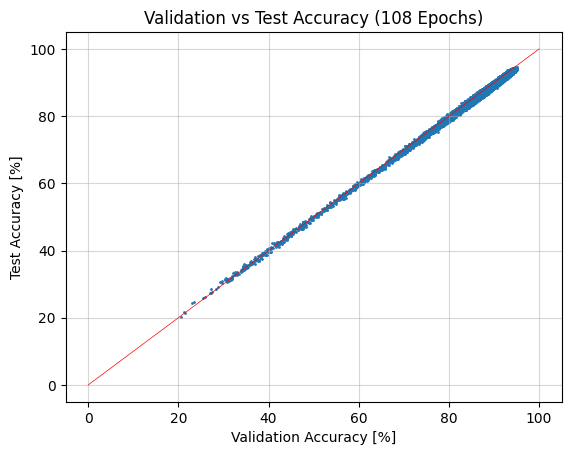

In [11]:
plt.scatter(val_accs_perc, test_acc_perc, s=1)
plt.plot([0, 100], [0, 100], color='red', linestyle='-', linewidth=0.5)
plt.grid(alpha=0.5)
plt.xlabel('Validation Accuracy [%]')
plt.ylabel('Test Accuracy [%]')
plt.title('Validation vs Test Accuracy (108 Epochs)')
plt.show()

### Training time - trainable parameters - validation accuracy
- inspired by the official [NAS-Bench-101 paper](https://arxiv.org/pdf/1902.09635.pdf)
- investigation of the relationship between the **number of parameters**, **training time**, and **validation accuracy** of the models in `NAS-Bench-101`

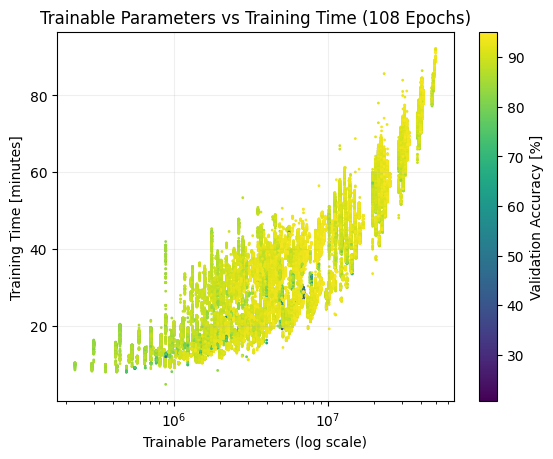

In [12]:
# Plot trainable parameters (log scale) vs. training time (minutes) colored by validation accuracy
plt.scatter(num_weights, train_time/60, s=1, c=val_accs_perc, cmap='viridis')
plt.colorbar(label='Validation Accuracy [%]')
plt.grid(alpha=0.2)
plt.xscale('log')
plt.xlabel('Trainable Parameters (log scale)')
plt.ylabel('Training Time [minutes]')
plt.title('Trainable Parameters vs Training Time (108 Epochs)')
plt.show()

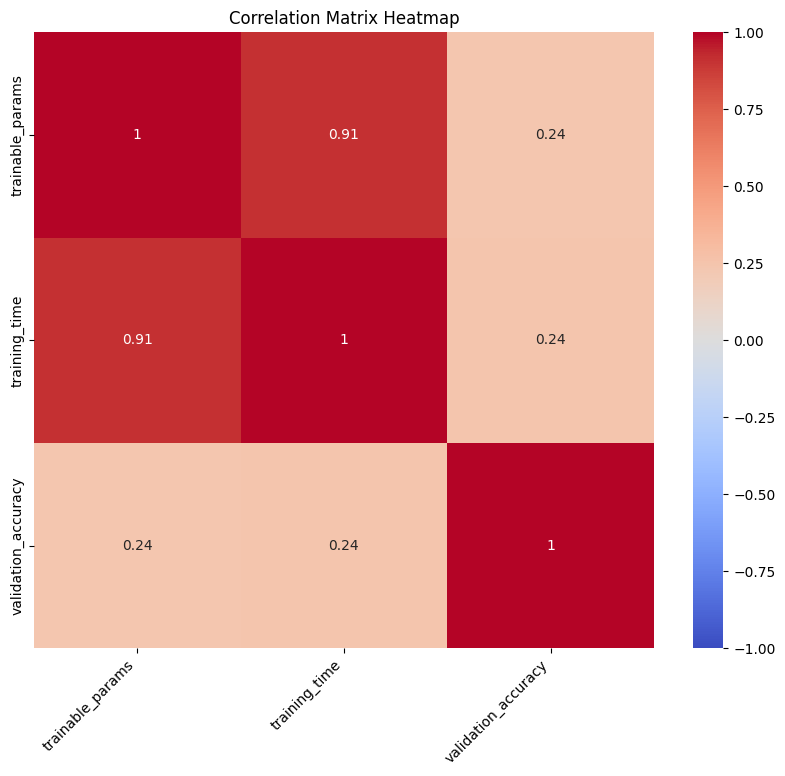

In [13]:
# Correlation between the number of parameters, training time and validation accuracy
data = pd.DataFrame({
    "trainable_params": num_weights,
    "training_time": train_time,
    "validation_accuracy": val_accs
})

show_correlation_matrix(data)

We can see that **training time** and **number of parameters** are highly correlated (`r=0.91`), which is expected, as the number of parameters is a good indicator of the complexity of the model.

The **validation accuracy** is only weakly correlated with the **training time** and the **number of parameters** (both `r=0.24`).

Because **validation accuracy** is the target in the performance prediction task, in the `analysis.ipynb` notebook, we will compare whether the **number of parameters** has some predictive power for the **validation accuracy** (not expected much better results, as the correlation is weak).

### Training time - validation accuracy

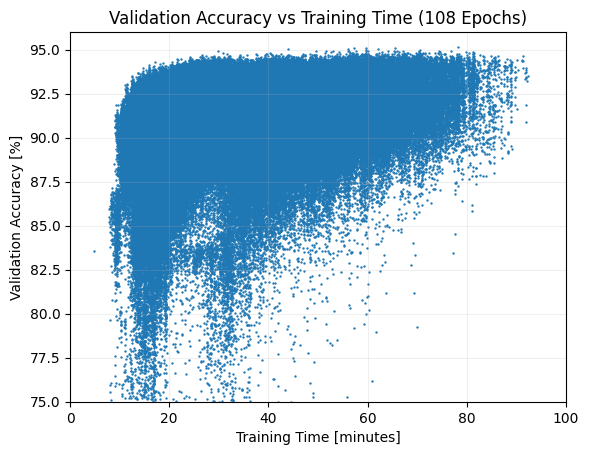

In [14]:
# Validation accuracy (y-axis) vs. number of training time (x-axis) - matplotlib
plt.scatter(train_time/60, val_accs_perc, s=0.5)
plt.grid(alpha=0.2)
plt.xlabel('Training Time [minutes]')
plt.ylabel('Validation Accuracy [%]')
plt.title('Validation Accuracy vs Training Time (108 Epochs)')
plt.ylim(75, 96)
plt.xlim(0, 100)
plt.show()

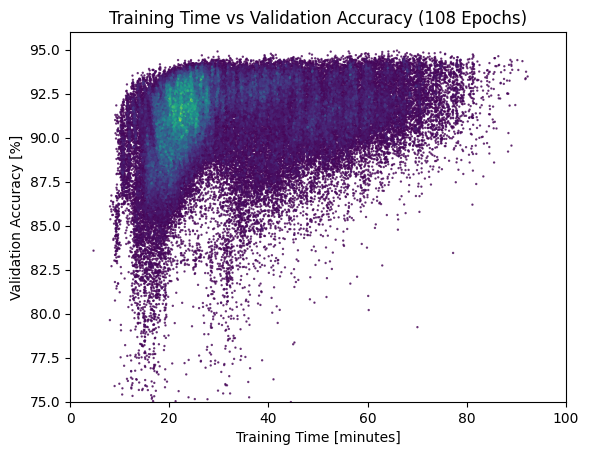

In [15]:
from sklearn.neighbors import KernelDensity
# Warning! takes long to run

# Get subset of 100_000
train_time_new = train_time[:100000]/60  # Convert to minutes
val_accs_perc_new = val_accs_perc[:100000]

data = np.vstack([train_time_new, val_accs_perc_new]).T

# Compute the density estimate
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(data)
z = np.exp(kde.score_samples(data))

# Create a scatter plot with gradient coloring based on the density estimate
plt.scatter(train_time_new, val_accs_perc_new, c=z, s=0.5, cmap='viridis', edgecolors='face', alpha=0.75)
plt.xlabel('Training Time [minutes]')
plt.ylabel('Validation Accuracy [%]')
plt.xlim(0, 100)
plt.ylim(75, 96)
plt.title('Training Time vs Validation Accuracy (108 Epochs)')
plt.show()

We can see from the plot above, that most of the architectures in `NAS-Bench-101` have **validation accuracy** close to 90% or higher.

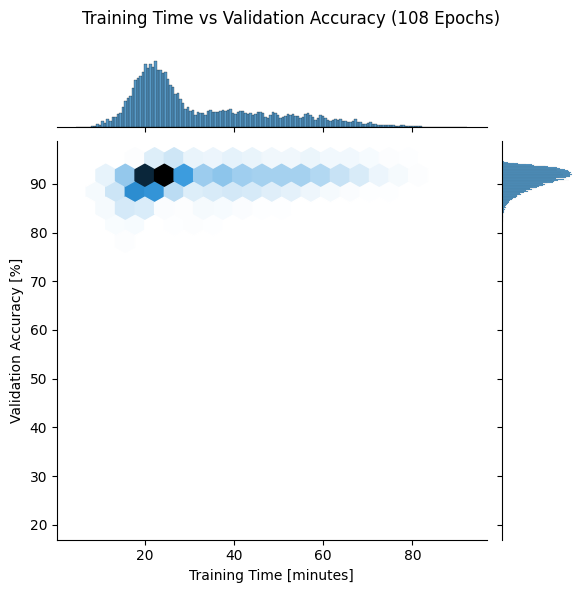

In [16]:
# Validation accuracy (y-axis) vs. number of training time (x-axis) - seaborn
df = pd.DataFrame({'Validation Accuracy [%]': val_accs_perc, 'Training Time [minutes]': train_time/60})
sns.jointplot(x='Training Time [minutes]', y='Validation Accuracy [%]', data=df, kind='hex', gridsize=20)
plt.subplots_adjust(top=0.9)
plt.suptitle('Training Time vs Validation Accuracy (108 Epochs)', fontsize=12)
plt.show()

### Number of trainable parameters - validation accuracy

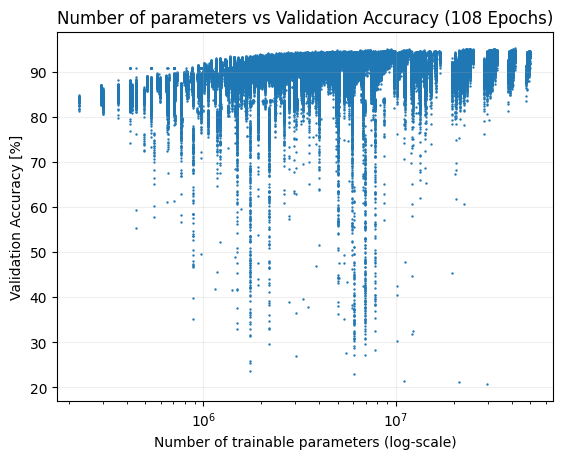

In [17]:
plt.scatter(num_weights, val_accs_perc, s=0.5)
plt.grid(alpha=0.2)
plt.xlabel('Number of trainable parameters (log-scale)')
plt.xscale('log')
plt.ylabel('Validation Accuracy [%]')
plt.title('Number of parameters vs Validation Accuracy (108 Epochs)')
plt.show()

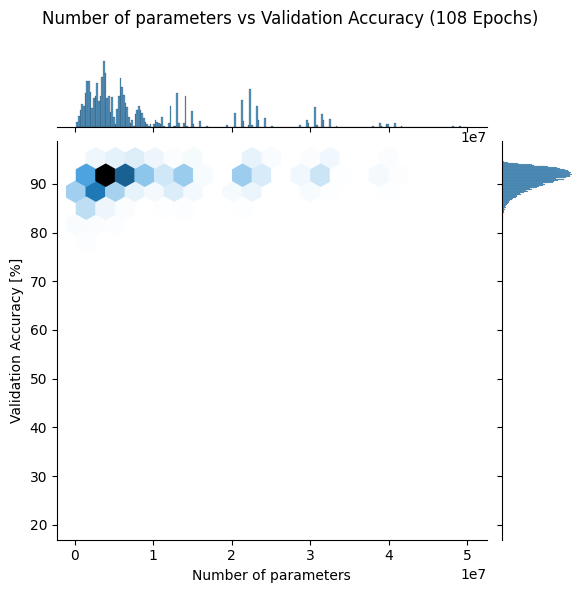

In [18]:
# Validation accuracy (y-axis) vs. number of training time (x-axis) - seaborn
df = pd.DataFrame({'Validation Accuracy [%]': val_accs_perc, 'Number of parameters': num_weights})
sns.jointplot(x='Number of parameters', y='Validation Accuracy [%]', data=df, kind='hex', gridsize=20)
plt.subplots_adjust(top=0.9)
plt.suptitle('Number of parameters vs Validation Accuracy (108 Epochs)', fontsize=12)
plt.show()

In [19]:
# Create a DataFrame with the derived features
data = pd.DataFrame({
    "trainable_params": num_weights,
    "num_connections": num_connections,
    "network_depth": net_depths,
    "num_vertices": num_vertices,
    "avg_connections_per_vertex": avg_connections_per_vertex,
    "conv3x3_count": conv3x3_count,
    "conv1x1_count": conv1x1_count,
    "maxpool3x3_count": maxpool3x3_count,
    "validation_accuracy": val_accs,
})

show_correlation_matrix(data, save=True, filename='imgs/correlation_matrix_new.pdf')

TypeError: show_correlation_matrix() got an unexpected keyword argument 'save_path'

In [ ]:
correlation_matrix = a.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

From the correlation matrix above, we can conclude that the potential features for the performance prediction task do not have a strong correlation with the target variable (**validation accuracy**). One of the most promising feature is the **number of trainable parameters** (`r=0.24`). 

Surprisingly, the **network depth** has a negative correlation with the **validation accuracy** (`r=-0.14`). 

The **conv3x3_count** has a moderate positive linear correlation with the **validation accuracy** (`r=0.46`). This suggests that as the number of 3x3 convolutional layers in the network increases, the validation accuracy tends to improve. This may be because 3x3 convolutions are capable of capturing spatial information effectively, which might be important for the problem. A higher **conv3x3_count** might provide the network with more capacity to learn complex patterns in the data. When the problem requires learning intricate features, a network with more capacity (more convolutional layers) might perform better. But we have to keep in mind that correlation does not imply causation. 

In the `analysis.ipynb` notebook, the **number of trainable parameters** and the **conv3x3_count** will be used as additional features for the performance prediction task, along with the **adjacency** and **operation** matrices (the most commonly used features for performance prediction).

The goal is to investigate whether the additional features can improve the performance of the model.